In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, classification_report

os.chdir('/home/ankushraut/Downloads/inter_iit_tech')
data = pd.read_csv('ExoTrain.csv')

In [191]:
data.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
1,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
2,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
3,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54
4,2,211.10,163.57,179.16,187.82,188.46,168.13,203.46,178.65,166.49,...,-98.45,30.34,30.34,29.62,28.80,19.27,-43.90,-41.63,-52.90,-16.16


In [192]:
target = pd.DataFrame({'LABEL':data.LABEL})
data = data.drop(labels = ['LABEL'], axis = 1)
target.LABEL.value_counts()

1    3927
2      33
Name: LABEL, dtype: int64

In [193]:
x_data, x_test, y_data, y_test = train_test_split(data, target, test_size = 0.15, random_state = 7)
x_data = x_data.reset_index(drop = True)
x_test = x_test.reset_index(drop = True)
y_data = y_data.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [194]:
y_data.LABEL.value_counts()

1    3335
2      31
Name: LABEL, dtype: int64

In [195]:
y_test.LABEL.value_counts()

1    592
2      2
Name: LABEL, dtype: int64

In [196]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size = .15, random_state = 7)
x_train = x_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
x_val = x_val.reset_index(drop = True)
y_val = y_val.reset_index(drop = True)

In [197]:
y_val.LABEL.value_counts()

1    499
2      6
Name: LABEL, dtype: int64

In [198]:
y_train.LABEL.value_counts()

1    2836
2      25
Name: LABEL, dtype: int64

In [199]:
#baseline approach : LABEL = 1
val = np.ones(len(y_train))
pred = np.ones(len(y_test))
print(f1_score(y_train.LABEL, val), f1_score(y_test.LABEL, pred))
bm_score = f1_score(y_test.LABEL, pred)

0.99561172547 0.998313659359


In [200]:
def for_xgb(data):
    if data == 1:
        data = 0
    else:
        data = 1
    return data

y_train['LABEL'] = y_train['LABEL'].map(lambda x: for_xgb(x))
y_test['LABEL'] = y_test['LABEL'].map(lambda x: for_xgb(x))
y_val['LABEL'] = y_val['LABEL'].map(lambda x: for_xgb(x))

In [201]:
y_val.head()

,LABEL
0,0
1,0
2,0
3,0
4,0


In [202]:
#baseline xgboost
params = {"objective":"binary:logistic",
          "booster":"gbtree",
          "eta":0.1,
          "max_depth": 10,
         "subsample":0.75,
          "silent":0,
         "seed":7,
         "lambda":5,
         "alpha":5,
         "eval_metric":"auc"}

num_boost_round = 100

x_tr = x_train
y_tr = y_train

dtrain = xgb.DMatrix(x_tr, y_tr)
dvalid = xgb.DMatrix(x_val, y_val)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

booster = xgb.train(params, dtrain, num_boost_round, evals = watchlist)

training_probs = booster.predict(xgb.DMatrix(x_train))
probs = []
for i in range(len(training_probs)):
    probs.append(training_probs[i])

check = booster.predict(xgb.DMatrix(x_val))
check_values = []
for i in range(len(check)):
    check_values.append(check[i])

[0]	train-auc:0.5	eval-auc:0.5
[1]	train-auc:0.5	eval-auc:0.5
[2]	train-auc:0.5	eval-auc:0.5
[3]	train-auc:0.5	eval-auc:0.5
[4]	train-auc:0.538237	eval-auc:0.498998
[5]	train-auc:0.573639	eval-auc:0.490982
[6]	train-auc:0.573639	eval-auc:0.490982
[7]	train-auc:0.573639	eval-auc:0.490982
[8]	train-auc:0.573639	eval-auc:0.490982
[9]	train-auc:0.742172	eval-auc:0.550768
[10]	train-auc:0.741157	eval-auc:0.551937
[11]	train-auc:0.741079	eval-auc:0.55177
[12]	train-auc:0.740388	eval-auc:0.550434
[13]	train-auc:0.740388	eval-auc:0.550434
[14]	train-auc:0.739556	eval-auc:0.550768
[15]	train-auc:0.739281	eval-auc:0.549933
[16]	train-auc:0.890818	eval-auc:0.690882
[17]	train-auc:0.908688	eval-auc:0.685204
[18]	train-auc:0.908286	eval-auc:0.683868
[19]	train-auc:0.944295	eval-auc:0.677856
[20]	train-auc:0.944979	eval-auc:0.675017
[21]	train-auc:0.947609	eval-auc:0.670007
[22]	train-auc:0.946213	eval-auc:0.664997
[23]	train-auc:0.948181	eval-auc:0.663661
[24]	train-auc:0.948893	eval-auc:0.657649
[

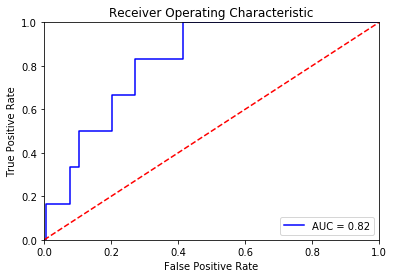

In [203]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = roc_curve(y_val, check_values)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [204]:
validation = pd.DataFrame({'LABEL':check_values})

In [205]:
def converter(thresh, data):
    if data <= thresh:
        data = 1
    else:
        data = 2
    return data

validation['LABEL'] = validation['LABEL'].map(lambda x: converter(0.02, x))

In [206]:
validation.head()

,LABEL
0,2
1,1
2,1
3,1
4,1


In [207]:
def reverse_xgb(data):
    if data == 0:
        data = 1
    else:
        data = 2
    return data
        
y_train['LABEL'] = y_train['LABEL'].map(lambda x: reverse_xgb(x))
y_test['LABEL'] = y_test['LABEL'].map(lambda x: reverse_xgb(x))
y_val['LABEL'] = y_val['LABEL'].map(lambda x: reverse_xgb(x))

In [208]:
print(f1_score(y_val, validation))
confusion_matrix(y_val, validation, labels = [1,2])

0.943277310924


array([[449,  50],
       [  4,   2]])

In [209]:
print(classification_report(y_val, validation))

             precision    recall  f1-score   support

          1       0.99      0.90      0.94       499
          2       0.04      0.33      0.07         6

avg / total       0.98      0.89      0.93       505



In [210]:
train_probs = pd.DataFrame({'LABEL':probs})
train_probs['LABEL'] = train_probs['LABEL'].map(lambda x: converter(0.02, x))

In [211]:
print(classification_report(y_train, train_probs))

             precision    recall  f1-score   support

          1       1.00      0.93      0.96      2836
          2       0.11      1.00      0.20        25

avg / total       0.99      0.93      0.96      2861



In [212]:
confusion_matrix(y_train, train_probs)

array([[2635,  201],
       [   0,   25]])

In [213]:
tester = booster.predict(xgb.DMatrix(x_test))
test_values = []
for i in range(len(tester)):
    test_values.append(tester[i])

In [255]:
test_pred = pd.DataFrame({'LABEL':test_values})
test_pred['LABEL'] = test_pred['LABEL'].map(lambda x: converter(0.004, x))

In [256]:
print(classification_report(y_test, test_pred))

             precision    recall  f1-score   support

          1       1.00      0.59      0.75       592
          2       0.01      1.00      0.02         2

avg / total       1.00      0.60      0.74       594



In [257]:
confusion_matrix(y_test, test_pred)

array([[352, 240],
       [  0,   2]])